In [291]:
from __future__ import print_function
import sys
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
import chess

In [292]:
url = "http://100.66.103.27:8080/video"

In [293]:
# coords = []
# def mouse_drawing(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print("Left click")
#         coords.append((x, y))

# cap = cv2.VideoCapture(url)

# cv2.namedWindow('image')
# cv2.setMouseCallback('image',mouse_drawing)

# while len(coords) < 4:
#     _, frame = cap.read()
    
#     cv2.imshow('image', frame)
    
    
#     k = cv2.waitKey(20) & 0xFF
#     if k == 27:
#         break
# cv2.destroyAllWindows()

In [347]:
cap = cv2.VideoCapture(url)


ret = False

while not ret:
    
    _, first_frame = cap.read()
    ret, res = cv2.findChessboardCorners(first_frame, (7, 7))
    
res = res[:,0, :]

In [348]:
min_x, max_x = res[:, 0].min(), res[:, 0].max()
min_y, max_y = res[:, 1].min(), res[:, 1].max()

dx = (max_x - min_x) / 6
dy = (max_y - min_y) / 6


board_corner = np.array([
                 [min_x - dx, max_y + dy],
                 [min_x - dx, min_y - dy],
                 [max_x + dx, max_y + dy],
                 [max_x + dx, min_y - dy],
                        ])

res = np.vstack((res, board_corner))

In [349]:
first_frame_copy = first_frame.copy()
for x, y in res:
    cv2.circle(first_frame_copy, (int(x), int(y)), 10, (0, 255, 0), -1)

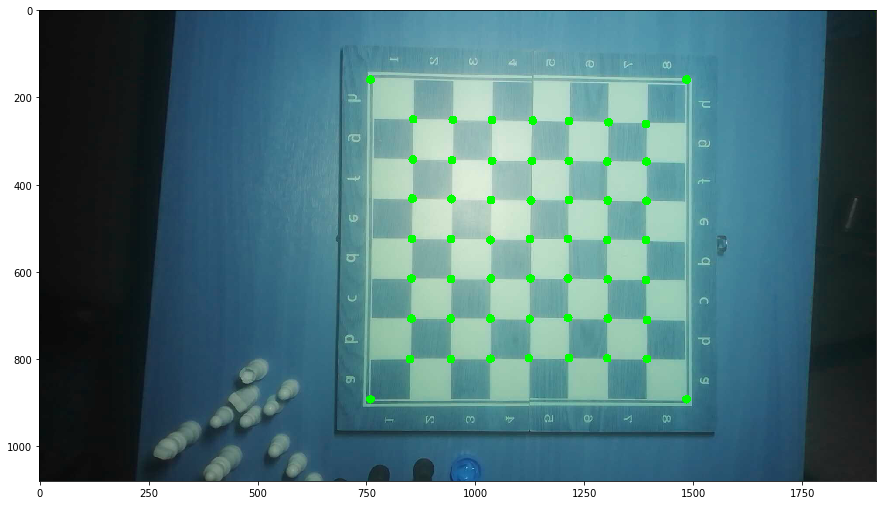

In [350]:
plt.figure(figsize=(15, 15))
plt.imshow(first_frame_copy)

In [351]:
width = 400

pst1 = np.float32(board_corner)
pst2 = np.float32([[0,0],[width,0],[0,width],[width,width]])

M = cv2.getPerspectiveTransform(pst1,pst2)
M

array([[-3.82699908e-17, -5.45572837e-01,  4.86908206e+02],
       [ 5.51879503e-01, -0.00000000e+00, -4.19721069e+02],
       [-9.80334876e-20,  0.00000000e+00,  1.00000000e+00]])

In [352]:
def getGridSum(img_gray):
    img_canny = cv2.Canny(img_gray, 20, 100)

    vert_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_canny.shape[1] / 40)))
    horr_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_canny.shape[1] / 40), 1))

    vertical = cv2.erode(img_canny, vert_rect)
    vertical = cv2.dilate(vertical, vert_rect)

    horizontal = cv2.erode(img_canny, horr_rect)
    horizontal = cv2.dilate(horizontal, horr_rect)


    img_grid = horizontal + vertical
    img_grid_sum = img_grid.sum()
    
    return int(img_grid_sum), img_grid

In [353]:
empty = first_frame.copy()
empty = cv2.warpPerspective(empty, M, (width, width))
empty_gray = cv2.cvtColor(empty, cv2.COLOR_BGR2GRAY)

chess_grid_sum, chess_grid = getGridSum(empty_gray)

In [354]:
def handOn(frame, frame_last, thr = 0.05):
    kernel = np.ones((3, 3))
    
    diff = cv2.absdiff(frame, frame_last)
    diff = cv2.threshold(diff, 10, 150, cv2.THRESH_BINARY)[1]
    diff = cv2.erode(diff, kernel)
    diff = cv2.dilate(diff, kernel)
    return (diff != 0).sum() / (diff.shape[0] * diff.shape[1]) > thr

In [369]:
def getMove(diff, board, step = 50, thr = 0.05):
    
    kernel = np.ones((5, 5))
    diff = cv2.threshold(diff, 0, 255, cv2.THRESH_OTSU)[1]
    diff = cv2.erode(diff, kernel)
    diff = cv2.dilate(diff, kernel)
    plt.imshow(diff)
    plt.show()
    
    cur_move = []
    for i in range(8):
        for j in range(78):
            sub_diff = diff[step*i:step*(i+1),step*j:step*(j+1)]
#             sub_diff = sub_diff[12:-12,12:-12]
            
            if (sub_diff != 0).sum() / (step*step) > thr:
                cur_move.append([i, j])
    print(cur_move)
    len_moves = len(cur_move)
    moves = []
    for i, j in cur_move:
        for k, l in cur_move:
            moves.append(chess.Move(j + i*8,l + k*8))
            
    res_move = None
    for move in moves:
        if move in board.legal_moves:
            res_move = move
            break
    
    return res_move

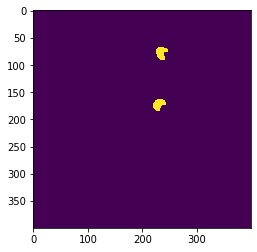

[[1, 4], [3, 4]]


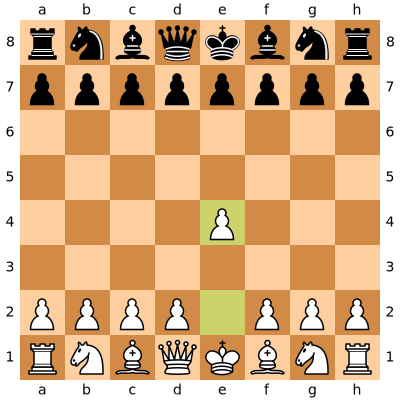

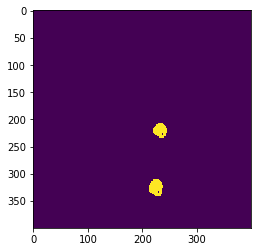

[[4, 4], [6, 4]]


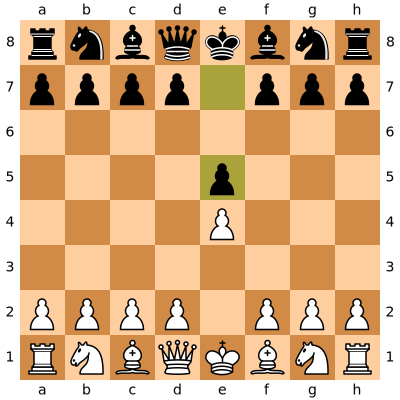

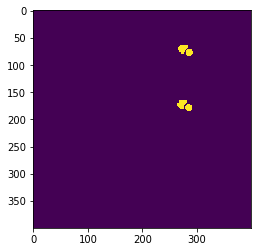

[[1, 5], [3, 5]]


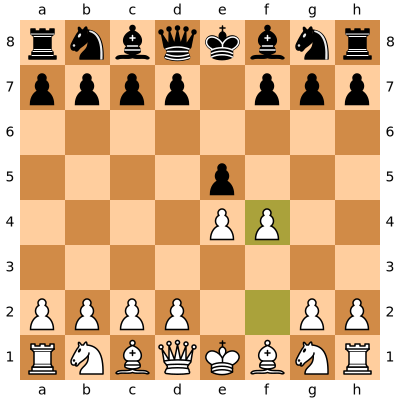

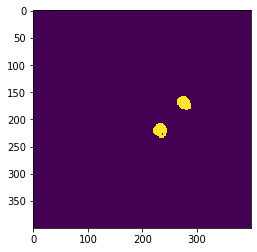

[[3, 5], [4, 4]]


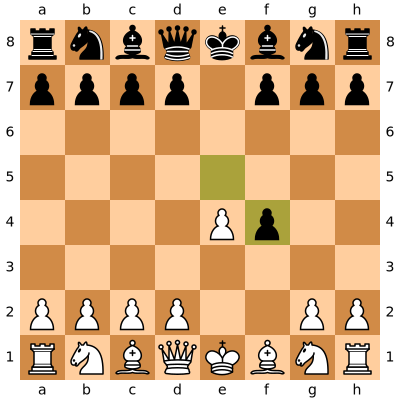

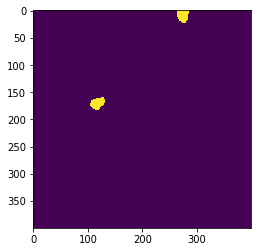

[[0, 5], [3, 2]]


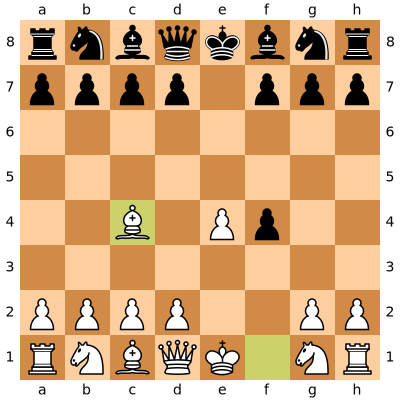

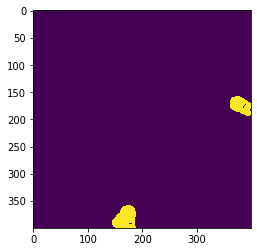

[[3, 7], [7, 3]]


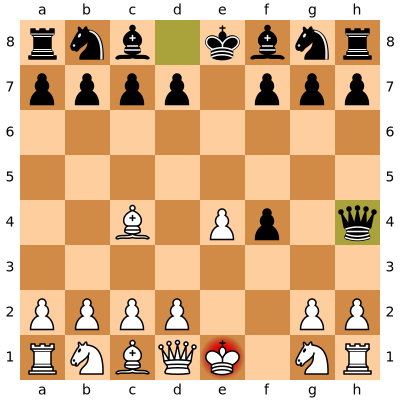

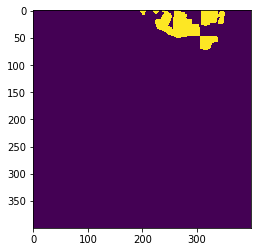

[[0, 4], [0, 5], [0, 6], [1, 6]]


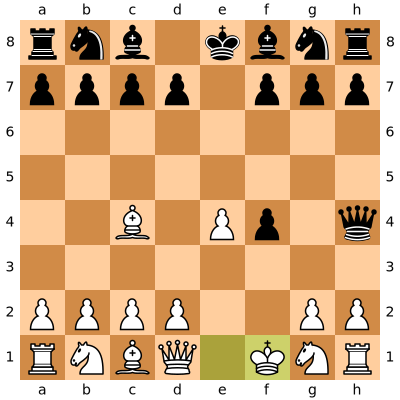

In [ ]:
cap = cv2.VideoCapture(url)
board = chess.Board()

_, frame_last = cap.read()
frame_last = cv2.warpPerspective(frame_last, M, (width, width))
frame_last = cv2.cvtColor(frame_last, cv2.COLOR_BGR2GRAY)
frame_last = frame_last

hand_on_last = False

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:

        frame = cv2.warpPerspective(frame, M, (width, width))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         frame = cv2.Canny(frame,50,100)
    #     frame = cv2.absdiff(frame, empty_gray)

        
#         
        hand_on_cur = handOn(frame, frame_last)
        hand_on_change = hand_on_cur ^ hand_on_last

        if hand_on_change and not hand_on_cur:
            time.sleep(2)
            _, frame = cap.read()
            frame = cv2.warpPerspective(frame, M, (width, width))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            diff = cv2.absdiff(frame, frame_last)

            cur_move = getMove(diff, board)
            board.push(cur_move)
            display(board)
            frame_last = frame.copy()

        hand_on_last = hand_on_cur
        
        msg_text = "hand on" if hand_on_cur else "hand off"
        # Display the resulting frame
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        frame = cv2.putText(frame, msg_text, (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('Frame',frame)


        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
        cap = cv2.VideoCapture(url)
    # Break the loop
    else: 
        break
 
# When everything done, release the video capture obj/ect
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

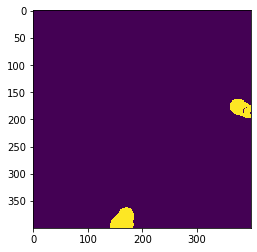

[]


In [361]:
getMove(diff, board)

In [ ]:
chess.Move()

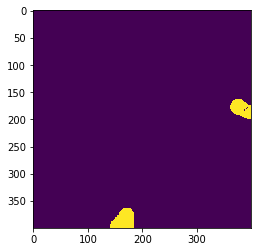

In [363]:
kernel = np.ones((6, 6))
diff_t = cv2.threshold(diff, 0, 255, cv2.THRESH_OTSU)[1]
diff_t = cv2.erode(diff_t, kernel)
diff_t = cv2.dilate(diff_t, kernel)

plt.imshow(diff_t)

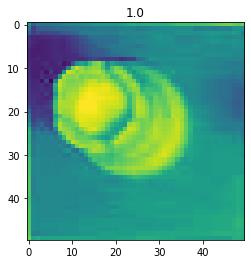

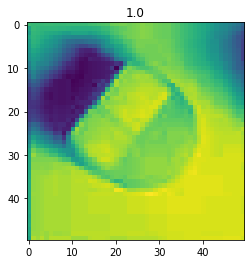

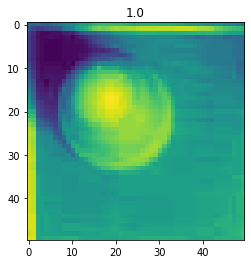

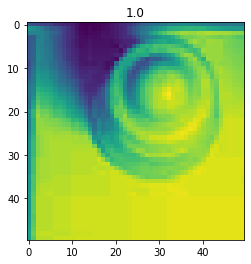

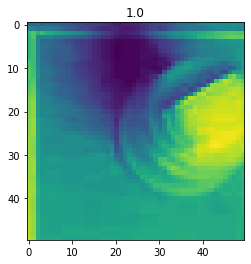

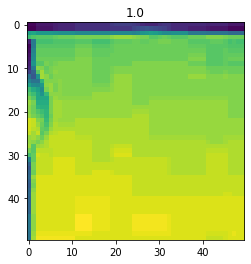

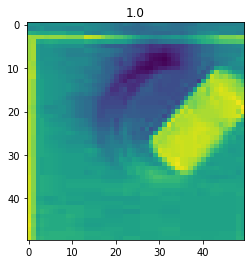

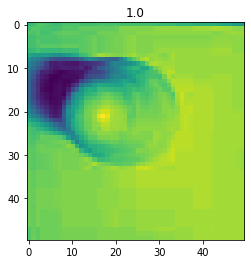

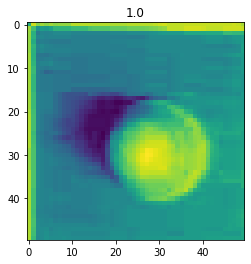

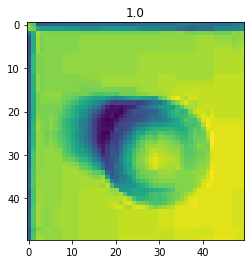

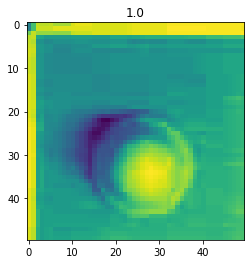

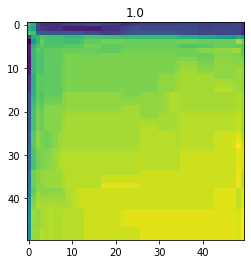

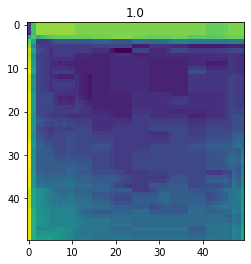

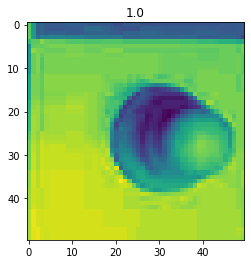

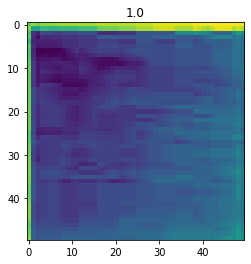

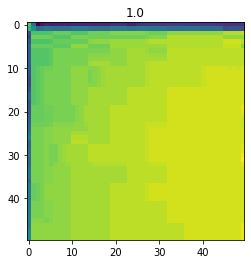

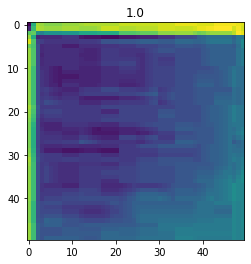

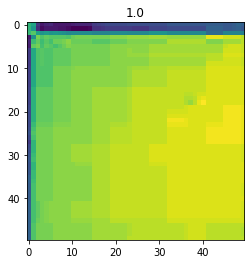

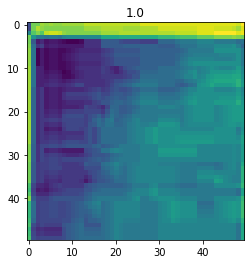

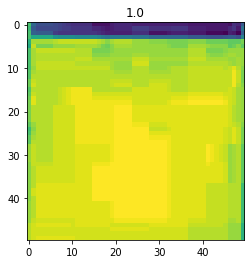

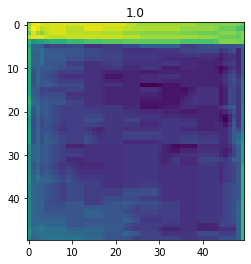

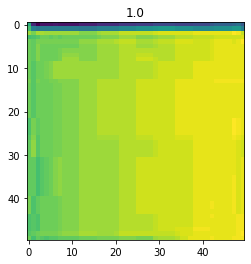

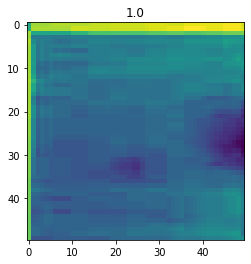

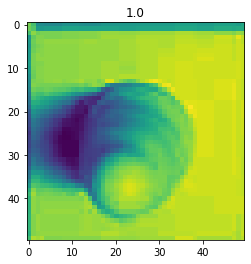

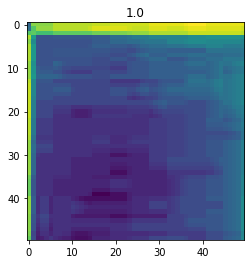

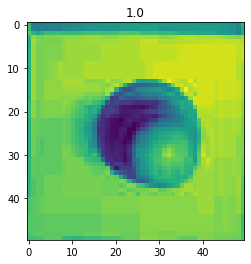

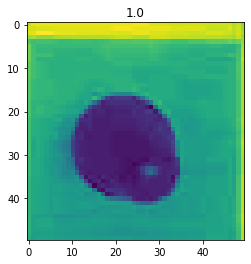

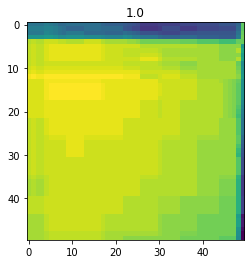

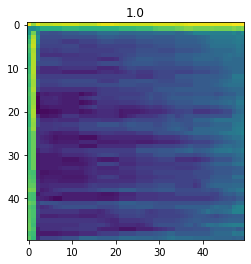

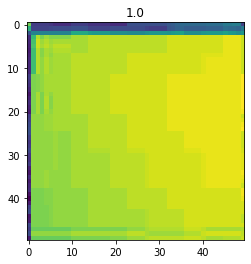

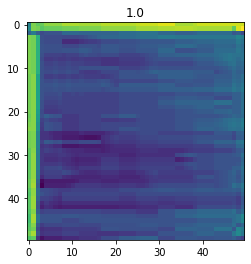

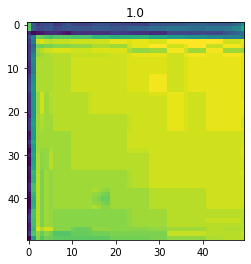

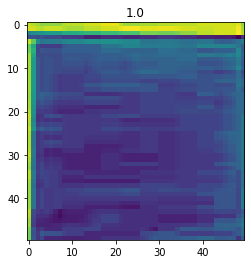

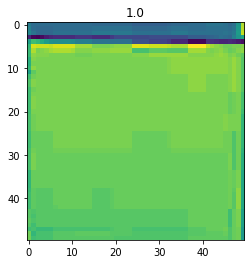

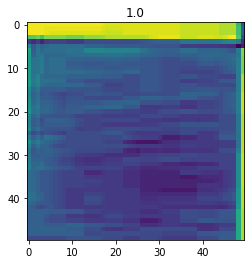

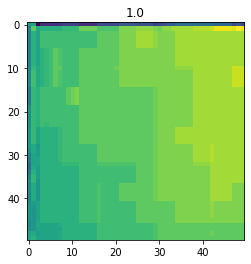

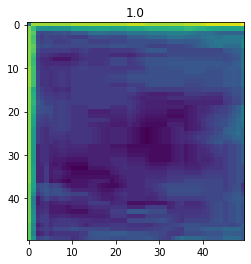

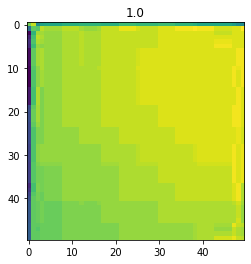

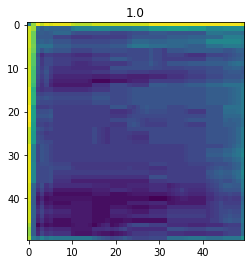

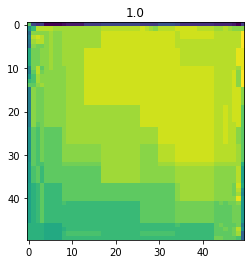

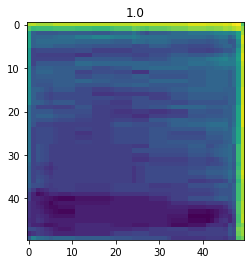

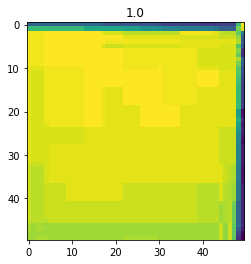

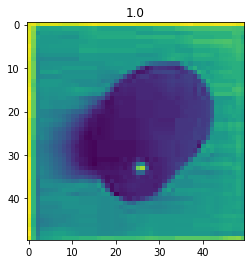

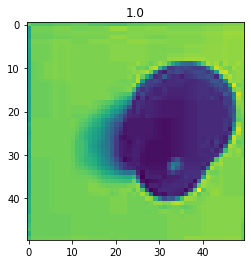

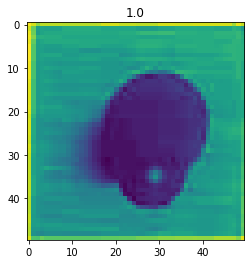

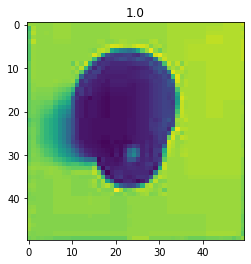

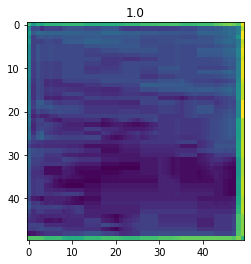

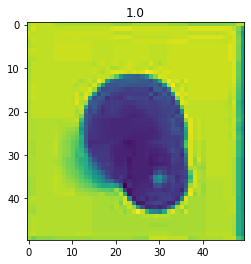

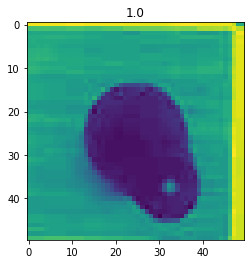

In [366]:
step = 50
cur_move = []
for i in range(7):
    for j in range(7):
        sub_diff = frame[step*i:step*(i+1),step*j:step*(j+1)]
#             sub_diff = sub_diff[12:-12,12:-12]

        cur_t = (sub_diff != 0).sum() / (step*step)
        
        plt.title(f"{cur_t}")
        plt.imshow(sub_diff)
        plt.show()
    
        if cur_t > 0.15:
            cur_move.append([i, j])

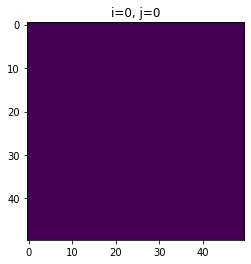

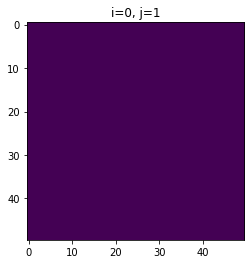

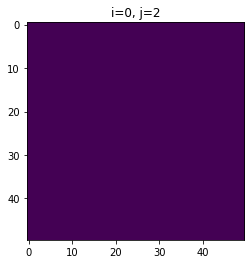

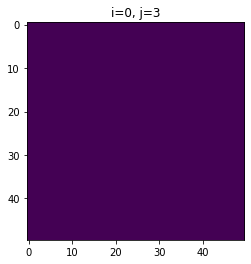

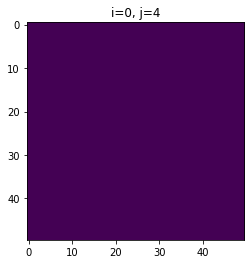

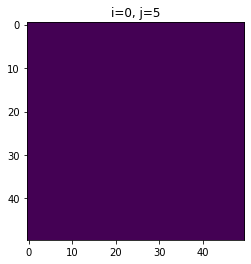

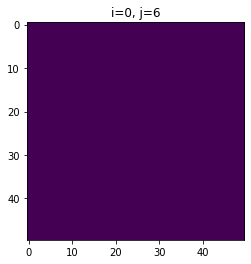

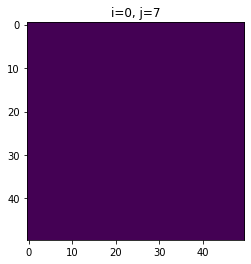

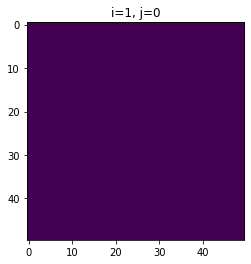

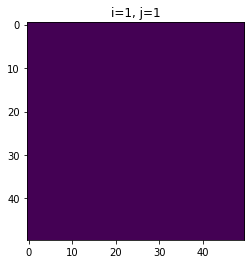

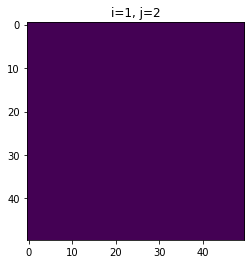

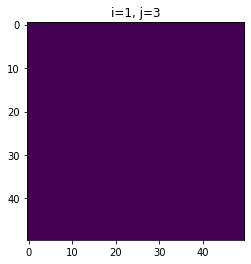

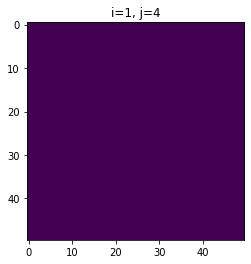

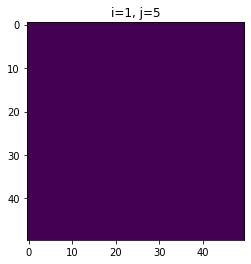

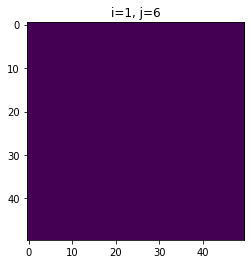

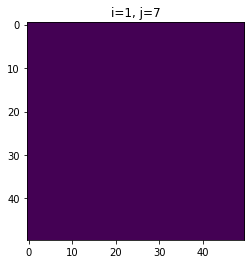

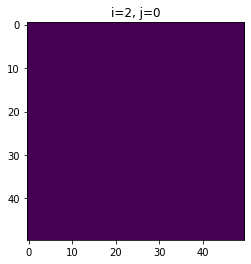

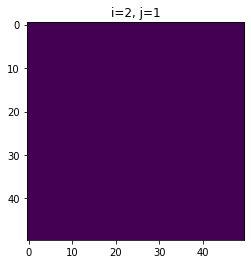

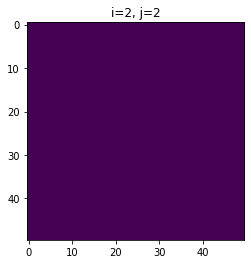

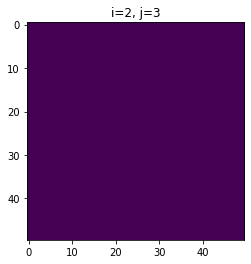

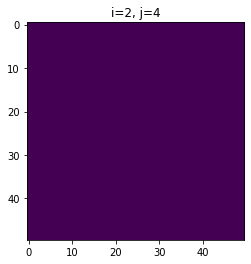

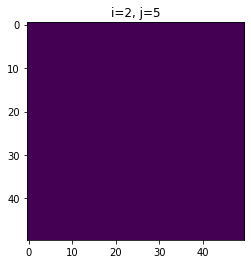

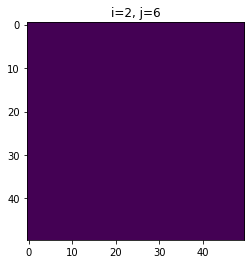

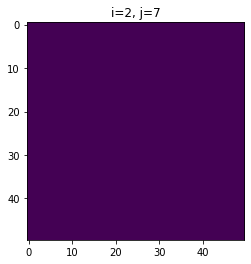

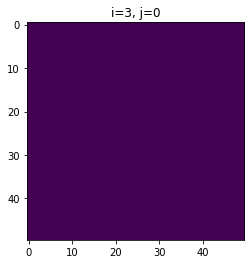

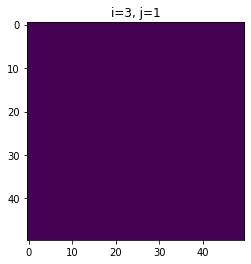

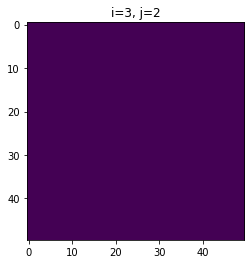

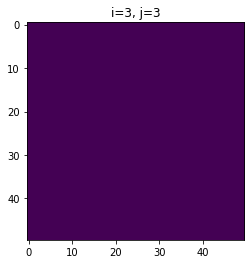

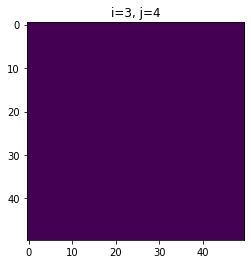

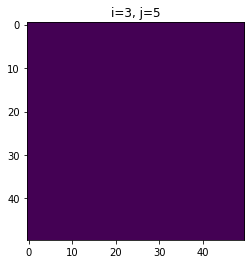

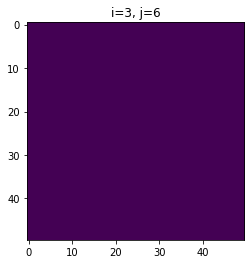

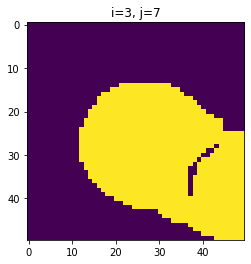

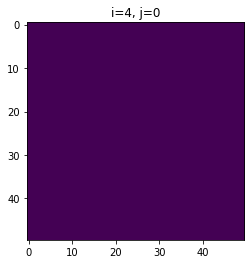

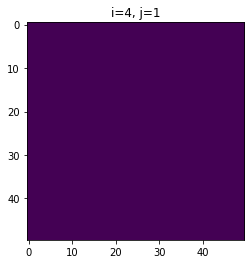

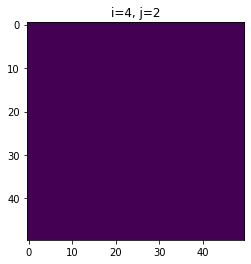

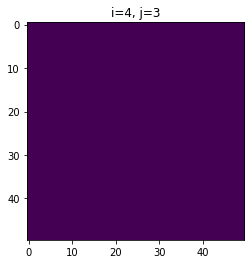

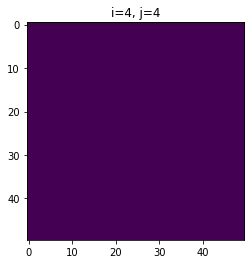

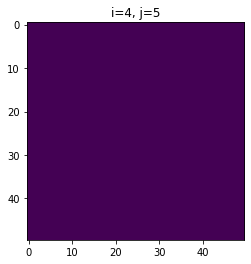

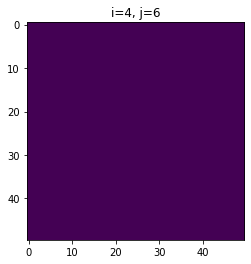

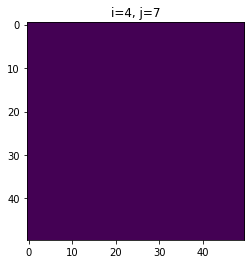

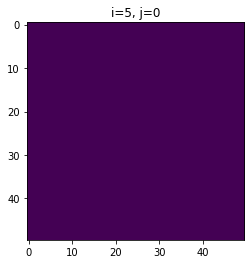

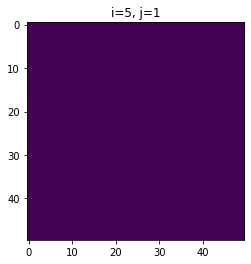

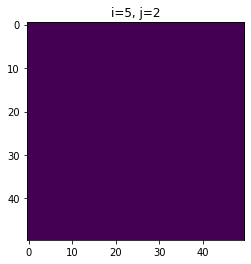

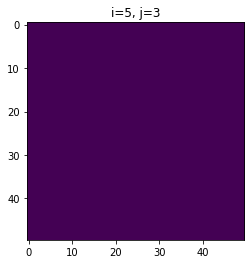

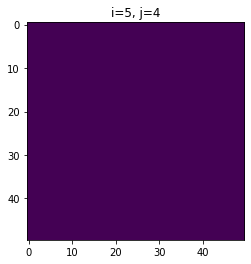

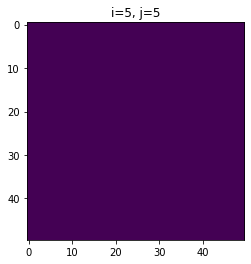

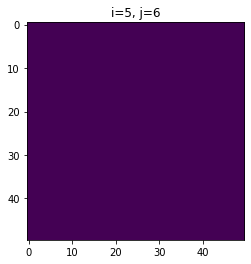

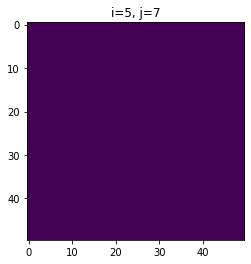

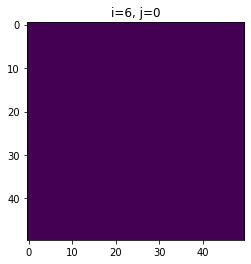

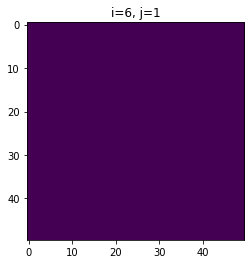

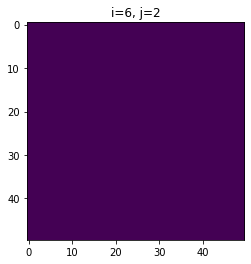

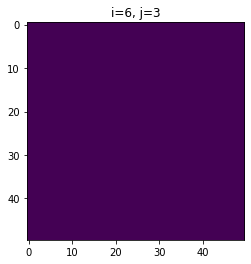

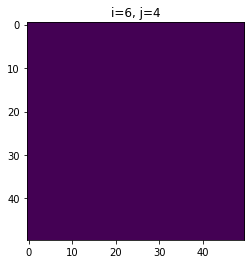

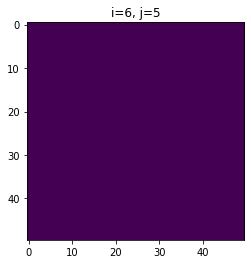

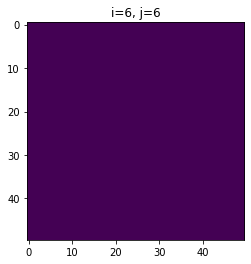

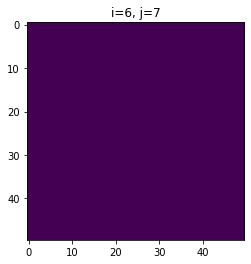

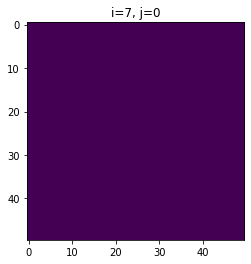

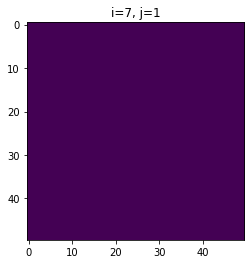

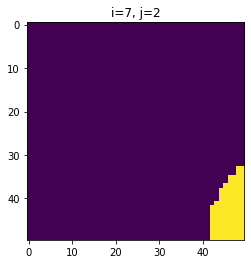

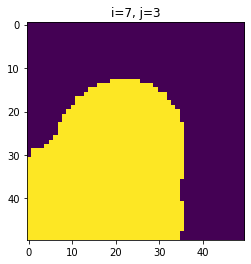

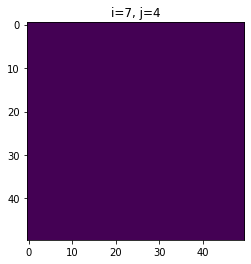

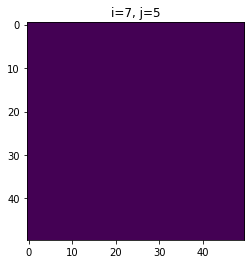

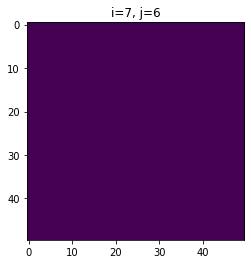

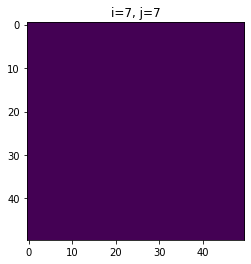

In [368]:
for i in range(8):
    for j in range(8):
        sub_diff = diff_t[step*i:step*(i+1),step*j:step*(j+1)]
        plt.title(f"i={i}, j={j}")
        plt.imshow(sub_diff)
        plt.show()

In [161]:
i, j = 0, 5
sub_diff = diff[step*i:step*(i+1),step*j:step*(j+1)]

In [162]:
sub_diff.mean()

1.3912

In [163]:
sub_diff.mean()

1.3912

In [157]:
diff.mean()

1.67051875

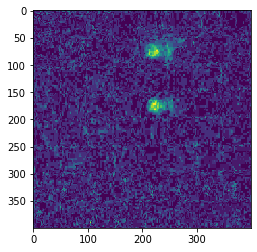

In [139]:
plt.imshow(diff)

In [126]:
(diff_t==255).sum() / (diff_t.shape[0]*diff_t.shape[1])

0.01033125

In [76]:
cur_grid_sum, t = getGridSum(frame)

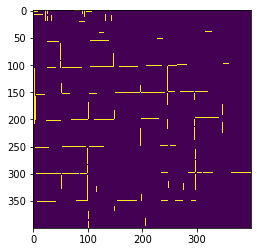

In [77]:
plt.imshow(t)

In [49]:
board = chess.Board()
len_moves = len(cur_move)
moves = []
for i, j in cur_move:
    for k, l in cur_move:
        moves.append(chess.Move(i + j*8, k * 8))

TypeError: object of type 'NoneType' has no len()

In [47]:
cur_move = None
for move in moves:
    if move in board.legal_moves:
        cur_move = move
        break

NameError: name 'moves' is not defined

In [90]:
board = chess.Board()

In [107]:
board.push(chess.Move(6, 21))

Move.from_uci('g1g1')

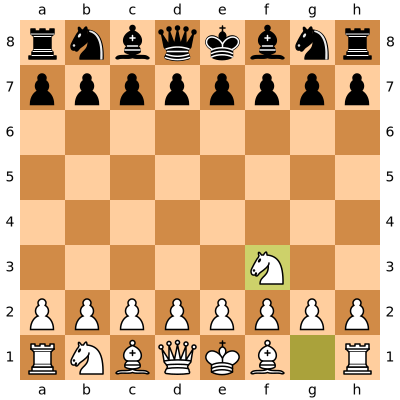

In [108]:
board

In [116]:
for i in board.generate_legal_moves():
    print(i)

g8h6
g8f6
b8c6
b8a6
h7h6
g7g6
f7f6
e7e6
d7d6
c7c6
b7b6
a7a6
h7h5
g7g5
f7f5
e7e5
d7d5
c7c5
b7b5
a7a5


In [106]:
chess.Move(6, 21)

Move.from_uci('g1f3')

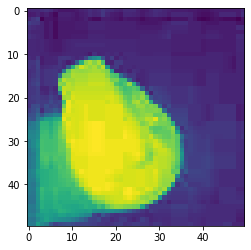

In [54]:
i, j = 2, 2
sub_diff = diff[step*i: step*(i+1), step*j: step*(j+1)]
plt.imshow(sub_diff)

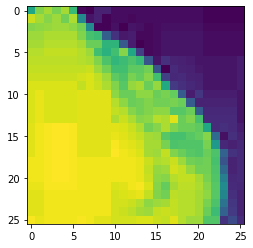

In [55]:
step_wrap = int(step / 4)

plt.imshow(sub_diff[step_wrap:-step_wrap, step_wrap:-step_wrap])

In [56]:
sub_diff[step_wrap:-step_wrap, step_wrap:-step_wrap].mean()

66.08579881656804

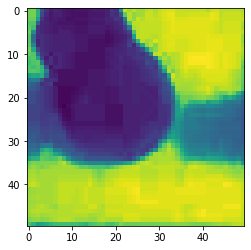

In [194]:
step = int(width / 8)
plt.imshow(frame[:step, :step])

In [195]:
frame.shape

(400, 400)

In [196]:
hand_on_last = False
hand_on_cur = handOn(frame)

hand_on_change = hand_on_cur ^ hand_on_last

if hand_on_change and not hand_on_cur:
    diff = cv2.absdiff(frame, last_frame)

    cur_move = getMove(diff)
    print(cur_move)
    last_frame = frame.copy()
        

hand_on_last = hand_on_cur

In [197]:
t, grid = getGridSum(frame)

In [199]:
t

1347916

In [202]:
(chess_grid_sum - t) / chess_grid_sum

0.12236767142731574

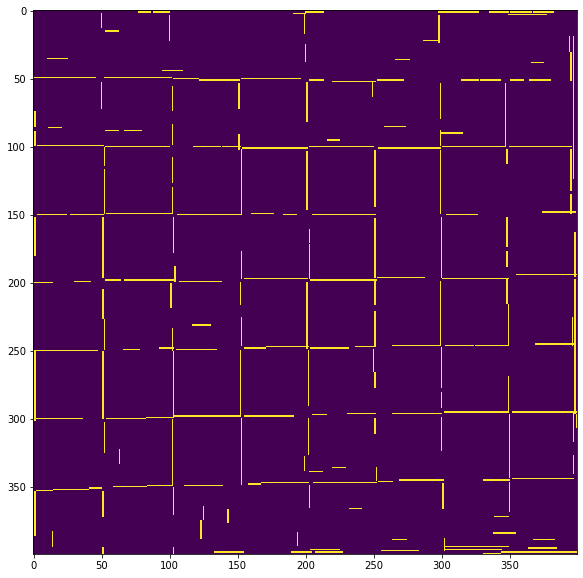

In [198]:
plt.figure(figsize=(10, 10))
plt.imshow(grid)